## [Corrective RAG (CRAG)](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag/#llms)

In [1]:
!pip install -qU langchain langsmith langchain-core langchain-community langchain-experimental langchain-openai langchain-groq pypdf langchain-text-splitters langchain-chroma faiss-cpu sentence_transformers google-search-results wikipedia duckduckgo-search arxiv langgraph yfinance

# Load Envs

In [2]:
import os
from google.colab import userdata
# os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
# os.environ['HUGGINGFACEHUB_API_TOKEN'] = userdata.get('HUGGINGFACEHUB_API_TOKEN')
os.environ['LANGSMITH_API_KEY'] = userdata.get('LANGSMITH_API_KEY')
# os.environ['SERPAPI_API_KEY'] = userdata.get('SERPAPI_API_KEY')

# Setup Langsmith

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_PROJECT"] = "langgraph_learning"

# LLM

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI()

# Import Nodes

### Corrective RAG (CRAG)¶
Corrective-RAG (CRAG) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents.

In the paper, a few steps are taken:

  * If at least one document exceeds the threshold for relevance, then it proceeds to generation
  * Before generation, it performs knowledge refinement
  * This partitions the document into "knowledge strips"
  * It grades each strip, and filters our irrelevant ones
  * If all documents fall below the relevance threshold or if the grader is unsure, then the framework seeks an additional datasource
  * It will use web search to supplement retrieval.


What this means?

1. Retriever Node:

  Based on user question, certain documents gets retrieved.

2. Grader Node:

  A grader node assess the  relevance of the retrieved document as per the user question.

3. Re-Writer Node:

  If the grader node says that the retreived node is not relevant, The Re-Writer node converts an input question to a better version that is optimized for web search.

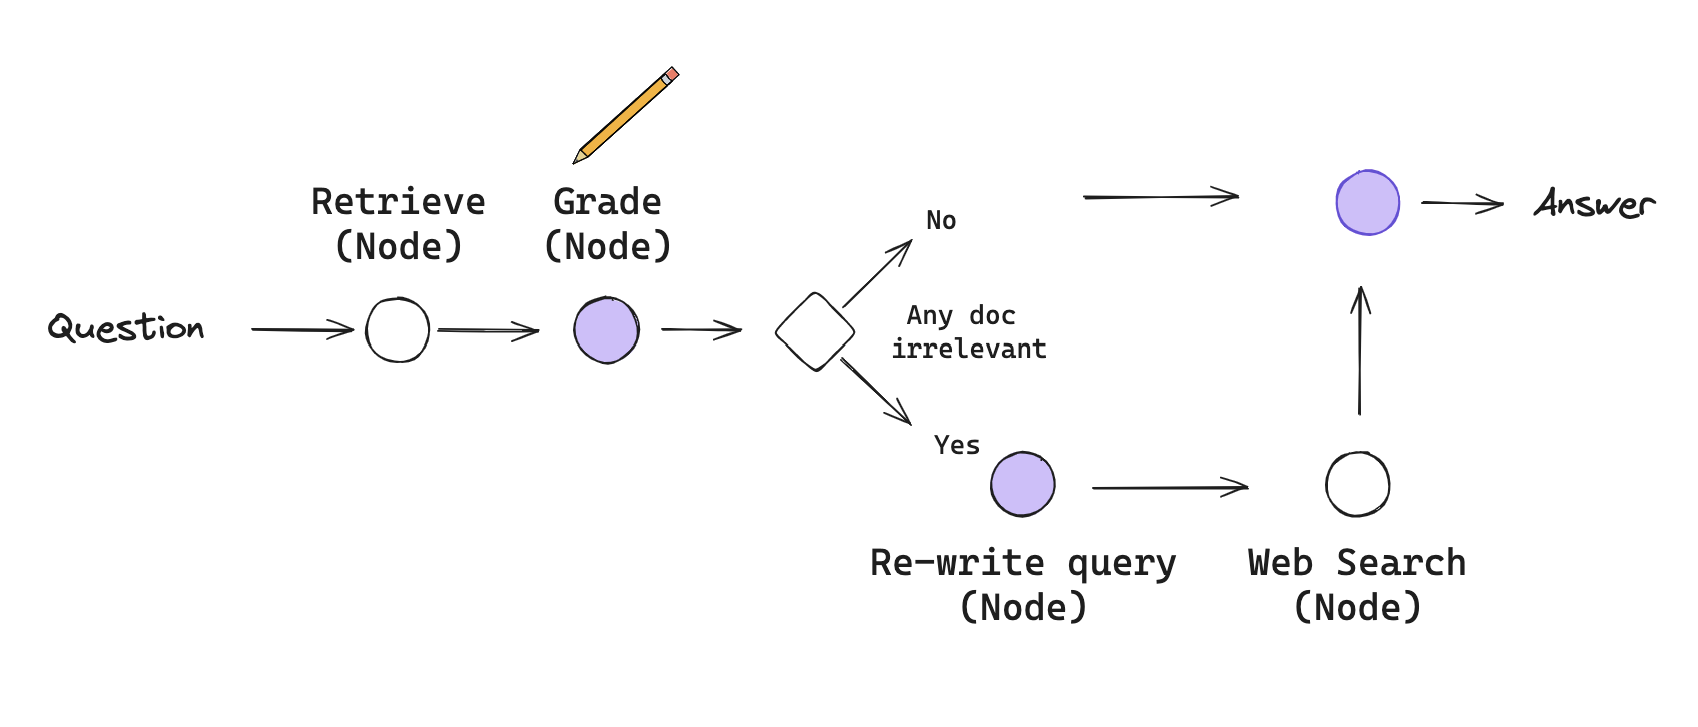

# 1. Retriever

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [10]:
# docs = [WebBaseLoader(url).load() for url in urls]

docs = []

for url in urls:
    loader = WebBaseLoader(url)
    print(loader.load())
    docs.append(loader.load())

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [11]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [13]:
# docs_list = [item for sublist in docs for item in sublist]
docs_list = []

for sublist in docs:
  print("sublist is : ", sublist)
  for item in sublist:
    print("item is : ", item)
    docs_list.append(item)

sublist is :  [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250,
    chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [18]:
retrieved_docs = retriever.invoke("Task Decomposition")
retrieved_docs

[Document(metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utiliz

In [17]:
retrieved_docs[0].page_content

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#'

# 2. Grader

Grader's respose is binary:
  1. Yes: This document is relevant.
  2. No: Document is not relevant.

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

### Structured Output

In [21]:
class GradeDocuments(BaseModel):
  """Binary score for relevance check on retrieved documents."""

  binary_score: str = Field(
      description="Documents are relevant to the question. 'yes' or 'no' "
  )

In [22]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [23]:
grader_system_prompt = """
  You are a grader assessing relevance of a retrieved document to a user question. \n
  If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
  Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question
""".strip()

In [24]:
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_system_prompt),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [25]:
retrieval_grader = grade_prompt | structured_llm_grader

Combine the retriever and grader together

In [26]:
question = "Task Decomposition"

In [27]:
docs = retriever.invoke(question)

In [28]:
doc_txt = docs[0].page_content

In [30]:
doc_txt

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#'

In [29]:
retrieval_grader.invoke({"question": question, "document": doc_txt,})

GradeDocuments(binary_score='yes')

# 3. Re-Writer Node

In [33]:
from langchain_core.output_parsers import StrOutputParser

In [34]:
re_write_prompt_template = """
  You a question re-writer that converts an input question to a better version that is optimized \n
  for web search. \n
  Look at the input and try to reason about the underlying semantic intent/meaning.
""".strip()

In [35]:
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", re_write_prompt_template),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [36]:
question = "Task Decomposition"
question_rewriter.invoke({"question": question})

'Optimized Web Search Version:\n"How can task decomposition be effectively utilized in project management?"'

# Other Nodes can be web search or generate output node

## Generate Node

In [37]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Task decomposition can be achieved by LLM through simple prompting, task-specific instructions, or human inputs. Another approach, LLM+P, involves using an external classical planner for long-horizon planning. Chain of thought and Tree of Thoughts are prompting techniques that help models decompose complex tasks into smaller steps.


# Build Graph

In [75]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [76]:
from typing_extensions import TypedDict
from typing import List

# Parent Class
class State(TypedDict):
  """
  Represents the state of our graph.

  Attributes:
    question: question
    generation: LLM generation
    web_search: whether to add search
    documents: list of documents
  """

  question: str
  generation: str
  web_search: str
  documents: List[str]

## Node 1: Retriever

In [77]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250,
    chunk_overlap=0
)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [78]:
def retriever_node(state: State) -> State:
  """
  Retrieve documents

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, documents, that contains retrieved documents

  """

  print("---RETRIEVE---")
  question = state["question"]

  # Retrieval
  retrieved_documents = retriever.invoke(question)

  return {"documents": retrieved_documents, "question": question}

## Node 2: Grade Documents

In [79]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

### Structured Output

In [80]:
class GradeDocuments(BaseModel):
  """Binary score for relevance check on retrieved documents."""

  binary_score: str = Field(
      description="Documents are relevant to the question. 'yes' or 'no' "
  )

In [81]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [82]:
grader_system_prompt = """
  You are a grader assessing relevance of a retrieved document to a user question. \n
  If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
  Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question
""".strip()

In [83]:
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_system_prompt),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [84]:
retrieval_grader = grade_prompt | structured_llm_grader

Testing

In [85]:
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [127]:
def grade_documents(state: State) -> State:
  """
  Determines whether the retrieved documents are relevant to the question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Updates documents key with only filtered relevant documents
  """

  print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
  question = state["question"]
  documents = state["documents"]

  # Score each docs
  filtered_docs = []
  web_search = "No" # default we say dont do web search

  for d in documents:
    doc_txt = d.page_content
    score = retrieval_grader.invoke(
        {"question": question, "document": doc_txt}
      )

    grade = score.binary_score

    if grade == "yes":
      print("---GRADE: DOCUMENT RELEVANT---")
      filtered_docs.append(d)
    else:
      print("---GRADE: DOCUMENT NOT RELEVANT---")
      web_search = "Yes"
      continue

  print("documents: ", filtered_docs)
  print("web_search: ", web_search)

  return {"documents": filtered_docs, "question": question, "web_search": web_search}


## Node 3: Generate Response Node

In [128]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

Testing

In [129]:
# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

Task decomposition in project management involves breaking down a large task or project into smaller, more manageable parts, often called deliverables. This process helps managers assign tasks more easily, assists in time management, and improves workflow efficiency. Utilizing tools and methods for task decomposition can streamline processes and improve overall project delivery.


In [130]:
def generate(state: State) -> State:
  """
  Generate answer

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, generation, that contains LLM generation
  """
  print("---GENERATE---")
  question = state["question"]
  documents = state["documents"]

  # RAG generation
  generation = rag_chain.invoke({"context": documents, "question": question})

  print("generated output: ", generation)

  return {"documents": documents, "question": question, "generation": generation}

## Node 4: Transform Query

In [131]:
from langchain_core.output_parsers import StrOutputParser

In [132]:
re_write_prompt_template = """
  You a question re-writer that converts an input question to a better version that is optimized \n
  for web search. \n
  Look at the input and try to reason about the underlying semantic intent/meaning.
""".strip()

In [133]:
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", re_write_prompt_template),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

Testing

In [134]:
question = "Task Decomposition"
question_rewriter.invoke({"question": question})

'What is task decomposition and how is it used in project management?'

In [135]:
def transform_query(state: State) -> State:
  """
  Transform the query to produce a better question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Updates question key with a re-phrased question
  """

  print("---TRANSFORM QUERY---")
  question = state["question"]
  documents = state["documents"]

  # Re-write question
  better_question = question_rewriter.invoke({"question": question})

  print("better question: ", better_question)
  return {"documents": documents, "question": better_question}

## Node 5: Web Search

In [136]:
from langchain_community.tools import DuckDuckGoSearchRun
web_search_tool = DuckDuckGoSearchRun()

Testing

In [137]:
question = "What is task decomposition and how is it used in project management?"
docs = web_search_tool.invoke({"query": question})

In [138]:
docs

'What is project decomposition? Project decomposition is the process of dividing components of a large project into smaller, more manageable portions, often called deliverables. This process helps managers assign tasks more easily and assists in time management and workflow. As team members complete tasks associated with their deliverables, they ... In project management, task decomposition can yield remarkable results. For example, consider a software development project. The main task might be "Develop a Mobile Application." By breaking it down into subtasks like user interface design, coding, testing, and deployment, the team can tackle each component systematically. Task Decomposition in Project Management. In project management, task decomposition is a crucial strategy. It helps teams outline project scopes, assign roles, and track progress effectively. Utilizing tools and methods for task decomposition can streamline processes and improve overall project delivery. You can explore

In [139]:
from langchain.schema import Document

In [148]:
def web_search(state):
  """
  Web search based on the re-phrased question.

  Args:
      state (dict): The current graph state

  Returns:
      state (dict): Updates documents key with appended web results
  """

  print("---WEB SEARCH---")
  question = state["question"]
  documents = state["documents"]

  # Web search
  docs = web_search_tool.invoke({"query": question})
  print(docs)

  # web_results = "\n".join([d["content"] for d in docs])
  web_results = "\n".join([d for d in docs])
  print(web_results)

  web_results = Document(page_content=web_results)
  print(web_results)

  documents.append(web_results)

  return {"documents": documents, "question": question}

# Router

In [149]:
def decide_to_generate(state: State) -> str:
  """
  Determines whether to generate an answer, or re-generate a question.

  Args:
    state (dict): The current graph state

  Returns:
    str: Binary decision for next node to call
  """

  print("---ASSESS GRADED DOCUMENTS---")
  print(state)

  state["question"]
  web_search = state["web_search"]
  state["documents"]

  if web_search == "Yes":
      # All documents have been filtered check_relevance
      # We will re-generate a new query
      print(
          "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
      )
      return "transform_query"
  else:
      # We have relevant documents, so generate answer
      print("---DECISION: GENERATE---")
      return "generate_response"

# Build Graph

In [150]:
from langgraph.graph import START, END, StateGraph

In [171]:
# 1. Create Instance of the Graph
workflow = StateGraph(State)


# 2. Create Nodes
workflow.add_node("retrieve", retriever_node)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search


# 3. Create Conditional Edges
workflow.add_conditional_edges(
    "grade_documents",   # Based on the grade decide the route.
    decide_to_generate, # The routing function
    {
        "transform_query" : "transform_query",
        "generate_response" : "generate"
    }
)

## Add Edges
workflow.add_edge("retrieve", "grade_documents")
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")

## Create Entry Point
workflow.add_edge(START, "retrieve")

### Create End Point
workflow.add_edge("generate", END)


# 4. Compile the Graph
my_graph = workflow.compile()
# my_graph = workflow.compile(checkpointer=memory)

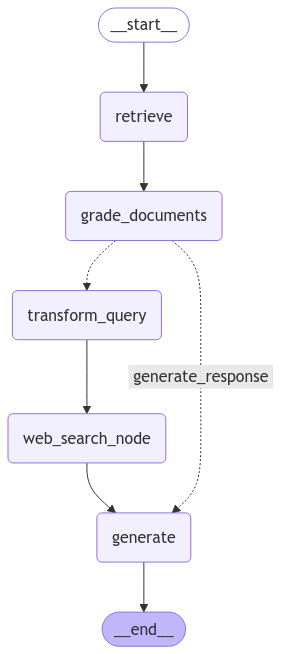

In [172]:
# 5. Display the graph
from IPython.display import Image, display

try:
    display(Image(my_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

# Run

In [173]:
config = {"configurable": {"thread_id": "1"}}

In [174]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}

In [175]:
# my_graph.stream(inputs, config, stream_mode="values")

for output in my_graph.stream(inputs):
  for key, value in output.items():
    # Node
    pprint(f"Node '{key}':")
    # Optional: print full state at each node
    # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
  pprint("\n---\n")

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
documents:  []
web_search:  Yes
---ASSESS GRADED DOCUMENTS---
{'documents': [], 'question': 'What are the types of agent memory?', 'web_search': 'Yes'}
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
better question:  What are the different types of memory used by agents?
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
While the exact shape of memory that your agent has may differ by application, we do see different high level types of memory. These types of memory are nothing new - they mimic human memory types. There's been some great work to map these human memory types to agent memory. My favorite is the CoALA paper. Below is my rough, ELI5 explanation ... Here is a sum

In [176]:
# Final generation
pprint(value["generation"])

('The different types of memory used by agents include long-term memory, '
 'semantic memory, and working memory. Long-term memory stores information for '
 'extended periods, semantic memory involves general knowledge and facts, and '
 'working memory is used for temporary storage and manipulation of '
 'information. These memory types play different roles in cognitive processes '
 'and problem-solving.')


In [177]:
pprint(value)

{'documents': [Document(metadata={}, page_content="W\nh\ni\nl\ne\n \nt\nh\ne\n \ne\nx\na\nc\nt\n \ns\nh\na\np\ne\n \no\nf\n \nm\ne\nm\no\nr\ny\n \nt\nh\na\nt\n \ny\no\nu\nr\n \na\ng\ne\nn\nt\n \nh\na\ns\n \nm\na\ny\n \nd\ni\nf\nf\ne\nr\n \nb\ny\n \na\np\np\nl\ni\nc\na\nt\ni\no\nn\n,\n \nw\ne\n \nd\no\n \ns\ne\ne\n \nd\ni\nf\nf\ne\nr\ne\nn\nt\n \nh\ni\ng\nh\n \nl\ne\nv\ne\nl\n \nt\ny\np\ne\ns\n \no\nf\n \nm\ne\nm\no\nr\ny\n.\n \nT\nh\ne\ns\ne\n \nt\ny\np\ne\ns\n \no\nf\n \nm\ne\nm\no\nr\ny\n \na\nr\ne\n \nn\no\nt\nh\ni\nn\ng\n \nn\ne\nw\n \n-\n \nt\nh\ne\ny\n \nm\ni\nm\ni\nc\n \nh\nu\nm\na\nn\n \nm\ne\nm\no\nr\ny\n \nt\ny\np\ne\ns\n.\n \nT\nh\ne\nr\ne\n'\ns\n \nb\ne\ne\nn\n \ns\no\nm\ne\n \ng\nr\ne\na\nt\n \nw\no\nr\nk\n \nt\no\n \nm\na\np\n \nt\nh\ne\ns\ne\n \nh\nu\nm\na\nn\n \nm\ne\nm\no\nr\ny\n \nt\ny\np\ne\ns\n \nt\no\n \na\ng\ne\nn\nt\n \nm\ne\nm\no\nr\ny\n.\n \nM\ny\n \nf\na\nv\no\nr\ni\nt\ne\n \ni\ns\n \nt\nh\ne\n \nC\no\nA\nL\nA\n \np\na\np\ne\nr\n.\n \nB\ne\nl\no\nw\n \ni\ns\n 